In [4]:
import csv
import cv2
import sklearn
import numpy as np
import random


samples = []
with open('./data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)

In [5]:
from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(samples,
                                                    test_size=0.2,
                                                    random_state=36)

In [6]:
def generator(samples, batch_size=64):
    nb_samples = len(samples)
    while 1:
        random.shuffle(samples)
        for offset in range(0, nb_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            
            images = []
            steering_angles = []
            for batch_sample in batch_samples:
                
                #set image path for center/left/right cameras
                center_path = './data/IMG/'+batch_sample[0].split('\\')[-1]
                left_path = './data/IMG/'+batch_sample[1].split('\\')[-1]
                right_path = './data/IMG/'+batch_sample[2].split('\\')[-1]
                
                #load images with cv2
                center_img = cv2.imread(center_path)
                left_img = cv2.imread(left_path)
                right_img = cv2.imread(right_path)
                
                #convert images from BGR to RGB to match drive.py color format
                center_img = cv2.cvtColor(center_img, cv2.COLOR_BGR2RGB)
                left_img = cv2.cvtColor(left_img, cv2.COLOR_BGR2RGB)
                right_img = cv2.cvtColor(right_img, cv2.COLOR_BGR2RGB)
                
                #set steering angles; apply +-0.2 to center steering angle for left/right cameras 
                steering_correction = 0.2
                
                steering_center = float(batch_sample[3])
                steering_left = steering_center + steering_correction
                steering_right = steering_center - steering_correction
                
                #flip images and steering angles to augment training data
                center_flip = cv2.flip(center_img, 1)
                left_flip = cv2.flip(center_img, 1)
                right_flip = cv2.flip(center_img, 1)
                
                steering_center_flip = -steering_center
                steering_left_flip = -steering_left
                steering_right_flip = -steering_right
                
                #add data to image/steering lists
                images.extend([center_img, left_img, right_img,
                               center_flip, left_flip, right_flip])
                steering_angles.extend([steering_center, steering_left, steering_right,
                                        steering_center_flip, steering_left_flip, steering_right_flip])
                
            X_train = np.array(images)
            y_train = np.array(steering_angles)
            
            yield sklearn.utils.shuffle(X_train, y_train)

In [11]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, Cropping2D, Lambda
from keras.regularizers import l2
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
tf.python.control_flow_ops = tf

In [8]:
### Hyperparameters
batch_size = 64
epochs = 20

In [9]:
train_generator = generator(train_samples, batch_size=batch_size)
validation_generator = generator(validation_samples, batch_size=batch_size)

In [10]:
x, y = next(train_generator)

In [19]:
input_shape = x.shape[1:]

model = Sequential()

model.add(Cropping2D(cropping=((50, 20), (0,0)), 
                     input_shape=(input_shape)))
model.add(Lambda(lambda x: x/127.5 - 1.0))

model.add(Conv2D(24,5,5,subsample=(2,2), W_regularizer='l2', activation='relu'))
model.add(Conv2D(36,5,5,subsample=(2,2), W_regularizer='l2', activation='relu'))
model.add(Conv2D(48,5,5,subsample=(2,2), W_regularizer='l2', activation='relu'))
model.add(Conv2D(64,3,3,subsample=(2,2), W_regularizer='l2', activation='relu'))
model.add(Conv2D(64,3,3,subsample=(2,2), W_regularizer='l2', activation='relu'))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(100))
model.add(Dropout(0.5))
model.add(Dense(50))
model.add(Dropout(0.5))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')

In [20]:
history = model.fit_generator(train_generator,
                              samples_per_epoch=len(train_samples * 6),
                              nb_epoch=epochs,
                              validation_data=validation_generator,
                              nb_val_samples=len(validation_samples * 6),
                              callbacks=[ModelCheckpoint('model.h5', save_best_only=True)])

Epoch 1/20
84132/84132 [==============================] - 194s - loss: 0.2270 - val_loss: 0.0390
Epoch 2/20
84132/84132 [==============================] - 185s - loss: 0.0411 - val_loss: 0.0378
Epoch 3/20
84132/84132 [==============================] - 185s - loss: 0.0401 - val_loss: 0.0361
Epoch 4/20
84132/84132 [==============================] - 184s - loss: 0.0397 - val_loss: 0.0375
Epoch 5/20
84132/84132 [==============================] - 185s - loss: 0.0395 - val_loss: 0.0389
Epoch 6/20
84132/84132 [==============================] - 185s - loss: 0.0397 - val_loss: 0.0405
Epoch 7/20
84132/84132 [==============================] - 185s - loss: 0.0394 - val_loss: 0.0362
Epoch 8/20
84132/84132 [==============================] - 185s - loss: 0.0391 - val_loss: 0.0369
Epoch 9/20
84132/84132 [==============================] - 185s - loss: 0.0392 - val_loss: 0.0362
Epoch 10/20
84132/84132 [==============================] - 191s - loss: 0.0392 - val_loss: 0.0390
Epoch 11/20
84132/84132 [====

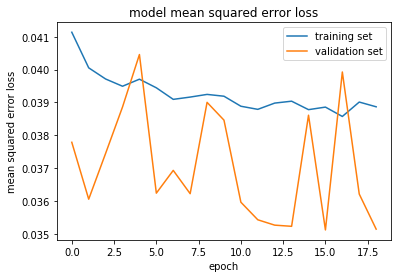

In [29]:
plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'][1:])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()